# **Convert cluster IDs into human interpretable form**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler

In [6]:
df = pd.read_parquet('../data/artifacts/zone_clusters.parquet').dropna()
df.shape

(253, 12)

In [7]:
df.head()

,PULocationID,zone,borough,avg_trip_duration,avg_trip_distance,pct_night_trips,pct_weekend_trips,pct_long_trips,pct_high_fare_trips,avg_fare_amount,avg_trips_per_day,cluster_id
0,7,Astoria,Queens,20.078063,2.651375,0.261216,0.340810,0.086831,0.308249,16.339197,43.187500,3
1,19,Bellerose,Queens,17.277004,5.291139,0.265823,0.126582,0.215190,0.632911,22.933544,3.434783,0
2,22,Bensonhurst West,Brooklyn,50.571396,5.461757,0.162162,0.256757,0.500000,0.716216,41.226081,2.551724,1
3,26,Borough Park,Brooklyn,31.615530,5.788977,0.079545,0.125000,0.500000,0.659091,34.042045,3.259259,0
4,29,Brighton Beach,Brooklyn,51.256140,12.441842,0.065789,0.171053,0.736842,0.855263,53.957237,3.040000,1


In [10]:
df.cluster_id.value_counts().sort_index()

cluster_id
0    113
1     53
2     49
3     38
Name: count, dtype: int64

# Cluster-Level Summary
* For each cluster, what is the average demand, distance, fare, and behavior?

In [12]:
features = [
    'avg_trip_distance',
    'avg_trip_duration',
    'avg_fare_amount',
    'avg_trips_per_day',
    'pct_night_trips',
    'pct_weekend_trips',
    'pct_high_fare_trips',
]

cluster_summary = df.groupby('cluster_id')[features].mean().round(2)
cluster_summary

,avg_trip_distance,avg_trip_duration,avg_fare_amount,avg_trips_per_day,pct_night_trips,pct_weekend_trips,pct_high_fare_trips
cluster_id,,,,,,,
0,4.53,25.02,30.46,20.85,0.18,0.23,0.65
1,9.32,40.22,46.77,151.25,0.19,0.23,0.86
2,2.46,12.78,14.05,1534.28,0.20,0.26,0.17
3,3.77,16.79,23.45,193.10,0.42,0.50,0.42


**Representative zones per cluster**

In [17]:
for k in sorted(df['cluster_id'].unique()):
    print(f'Cluster {k} representative zones:')
    display(
        df[df['cluster_id'] == k][['zone', 'borough']].head(10)
    )

Cluster 0 representative zones:


,zone,borough
1,Bellerose,Queens
3,Borough Park,Brooklyn
5,Brooklyn Navy Yard,Brooklyn
6,Columbia Street,Brooklyn
7,Downtown Brooklyn/MetroTech,Brooklyn
8,East New York/Pennsylvania Avenue,Brooklyn
11,Hunts Point,Bronx
14,Morrisania/Melrose,Bronx
16,Prospect-Lefferts Gardens,Brooklyn
18,Rego Park,Queens


Cluster 1 representative zones:


,zone,borough
2,Bensonhurst West,Brooklyn
4,Brighton Beach,Brooklyn
12,Jamaica,Queens
13,Marine Park/Mill Basin,Brooklyn
17,Queens Village,Queens
21,Starrett City,Brooklyn
28,Kingsbridge Heights,Bronx
30,Madison,Brooklyn
37,Canarsie,Brooklyn
41,Fresh Meadows,Queens


Cluster 2 representative zones:


,zone,borough
10,Greenwich Village North,Manhattan
23,Upper East Side South,Manhattan
26,Clinton West,Manhattan
32,Sutton Place/Turtle Bay North,Manhattan
33,Yorkville East,Manhattan
38,Central Park,Manhattan
45,Lincoln Square West,Manhattan
46,Long Island City/Hunters Point,Queens
55,Midtown Center,Manhattan
56,Queensbridge/Ravenswood,Queens


Cluster 3 representative zones:


,zone,borough
0,Astoria,Queens
9,Greenpoint,Brooklyn
15,Pelham Bay Park,Bronx
19,Ridgewood,Queens
29,Little Italy/NoLiTa,Manhattan
31,Prospect Park,Brooklyn
48,Park Slope,Brooklyn
54,Two Bridges/Seward Park,Manhattan
57,Arrochar/Fort Wadsworth,Staten Island
66,Meatpacking/West Village West,Manhattan


**Name clusters by cluster summary and zone samples**

In [60]:
cluster_names = {
    0: "Residential / Low-Demand Zones",
    1: "Airports & Long-Haul Zones",
    2: "Business & Commercial Hubs",
    3: "Nightlife / Mixed-Use Zones"
}

df['cluster_name'] = df['cluster_id'].map(cluster_names)
df[['cluster_id', 'cluster_name']].drop_duplicates().sort_values('cluster_id')

,cluster_id,cluster_name
1,0,Residential / Low-Demand Zones
2,1,Airports & Long-Haul Zones
10,2,Business & Commercial Hubs
0,3,Nightlife / Mixed-Use Zones


**Validate interpretations**

In [39]:
# Highest Demand Zones
df.sort_values("avg_trips_per_day", ascending=False).head(10)[
    ["zone", "borough", "avg_trips_per_day", "cluster_name"]
]

,zone,borough,avg_trips_per_day,cluster_name
23,Upper East Side South,Manhattan,4698.612903,Airports & Long-Haul Zones
133,JFK Airport,Queens,4564.171429,Residential / Low-Demand Zones
84,Upper East Side North,Manhattan,4359.741935,Airports & Long-Haul Zones
55,Midtown Center,Manhattan,4171.062500,Airports & Long-Haul Zones
166,Penn Station/Madison Sq West,Manhattan,3383.125000,Airports & Long-Haul Zones
172,Midtown East,Manhattan,3249.406250,Airports & Long-Haul Zones
121,Lincoln Square East,Manhattan,3064.843750,Airports & Long-Haul Zones
182,Times Sq/Theatre District,Manhattan,3047.062500,Airports & Long-Haul Zones
80,Murray Hill,Manhattan,2795.064516,Airports & Long-Haul Zones
104,LaGuardia Airport,Queens,2693.151515,Residential / Low-Demand Zones


In [40]:
# Highest Fares Zones
df.sort_values("avg_fare_amount", ascending=False).head(10)[
    [
        "zone",
        "borough",
        "avg_fare_amount",
        "cluster_name"
    ]
]

,zone,borough,avg_fare_amount,cluster_name
88,Newark Airport,EWR,87.988020,Business & Commercial Hubs
238,Great Kills,Staten Island,79.800000,Residential / Low-Demand Zones
89,Arden Heights,Staten Island,64.378571,Residential / Low-Demand Zones
101,Grymes Hill/Clifton,Staten Island,63.975000,Business & Commercial Hubs
90,Baisley Park,Queens,62.298551,Residential / Low-Demand Zones
117,Whitestone,Queens,59.184091,Residential / Low-Demand Zones
68,South Jamaica,Queens,58.862433,Residential / Low-Demand Zones
133,JFK Airport,Queens,58.624030,Residential / Low-Demand Zones
237,Flushing Meadows-Corona Park,Queens,58.352611,Residential / Low-Demand Zones
112,South Beach/Dongan Hills,Staten Island,56.831579,Residential / Low-Demand Zones


In [34]:
# Longest trips
df.sort_values("avg_trip_distance", ascending=False).head(10)[
    ["zone", "borough", "avg_trip_distance", "cluster_name"]
]

,zone,borough,avg_trip_distance,cluster_name
89,Arden Heights,Staten Island,18.196429,Residential / Low-Demand Zones
180,Heartland Village/Todt Hill,Staten Island,16.139000,Residential / Low-Demand Zones
133,JFK Airport,Queens,15.085444,Residential / Low-Demand Zones
130,Charleston/Tottenville,Staten Island,14.214667,Residential / Low-Demand Zones
90,Baisley Park,Queens,13.347481,Residential / Low-Demand Zones
112,South Beach/Dongan Hills,Staten Island,12.934211,Residential / Low-Demand Zones
200,Bloomfield/Emerson Hill,Staten Island,12.926019,Residential / Low-Demand Zones
126,Gravesend,Brooklyn,12.789559,Residential / Low-Demand Zones
4,Brighton Beach,Brooklyn,12.441842,Residential / Low-Demand Zones
148,Mariners Harbor,Staten Island,11.984000,Residential / Low-Demand Zones


**Visualization**

In [41]:
plt.figure(figsize=(11, 7))

<Figure size 1100x700 with 0 Axes>

<Figure size 1100x700 with 0 Axes>

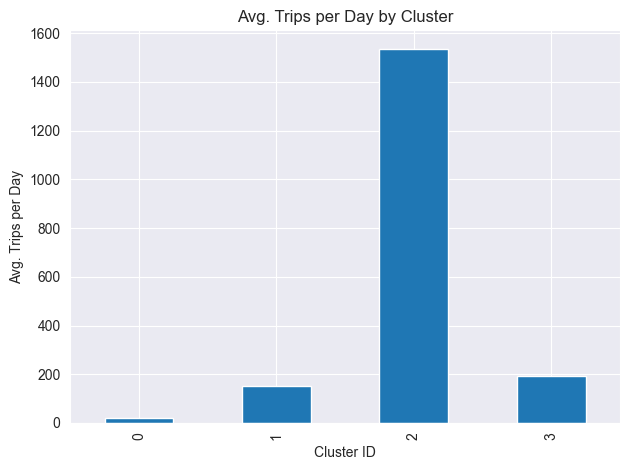

In [45]:
# Avg. Demand by cluster
cluster_summary['avg_trips_per_day'].plot(kind='bar', title='Avg. Trips per Day by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Avg. Trips per Day')
plt.tight_layout()
plt.show()

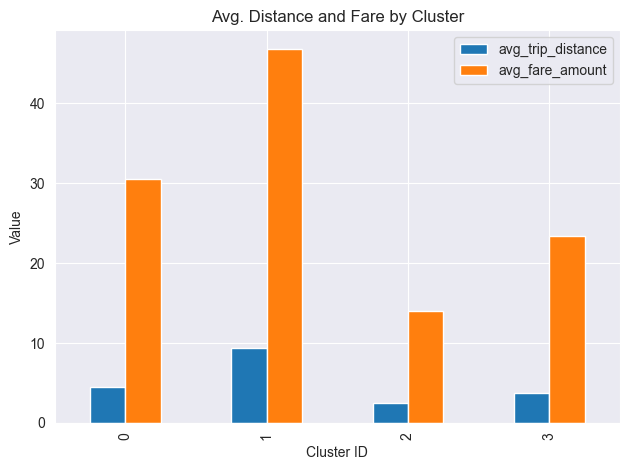

In [47]:
# Avg. Distance and Fare by Cluster
cluster_summary[['avg_trip_distance', 'avg_fare_amount']].plot(kind='bar', title='Avg. Distance and Fare by Cluster')
plt.xlabel('Cluster ID')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

**Final Report**

In [61]:
final_table = df[
    [
        "PULocationID",
        "zone",
        "borough",
        "cluster_id",
        "cluster_name"
    ]
    + features
].sort_values(['cluster_id', 'avg_trips_per_day'], ascending=False)

final_table

,PULocationID,zone,borough,cluster_id,cluster_name,avg_trip_distance,avg_trip_duration,avg_fare_amount,avg_trips_per_day,pct_night_trips,pct_weekend_trips,pct_high_fare_trips
79,79,East Village,Manhattan,3,Nightlife / Mixed-Use Zones,3.352645,14.260304,14.896190,2364.281250,0.524367,0.493530,0.202043
100,114,Greenwich Village South,Manhattan,3,Nightlife / Mixed-Use Zones,2.452355,14.671647,14.817085,1245.677419,0.535089,0.441061,0.211415
240,148,Lower East Side,Manhattan,3,Nightlife / Mixed-Use Zones,3.027970,16.765558,16.952045,929.000000,0.662406,0.588368,0.275969
66,158,Meatpacking/West Village West,Manhattan,3,Nightlife / Mixed-Use Zones,2.783344,15.666713,16.438833,749.806452,0.374075,0.409439,0.229780
29,144,Little Italy/NoLiTa,Manhattan,3,Nightlife / Mixed-Use Zones,2.606175,16.155786,15.906943,743.612903,0.380357,0.411418,0.250390
...,...,...,...,...,...,...,...,...,...,...,...,...
243,183,Pelham Bay,Bronx,0,Residential / Low-Demand Zones,5.442273,31.267424,34.168182,1.222222,0.136364,0.227273,0.681818
35,31,Bronx Park,Bronx,0,Residential / Low-Demand Zones,5.553750,29.397917,43.512500,1.142857,0.000000,0.250000,0.750000
87,253,Willets Point,Queens,0,Residential / Low-Demand Zones,6.251250,16.693750,49.950000,1.000000,0.125000,0.000000,0.625000
99,111,Green-Wood Cemetery,Brooklyn,0,Residential / Low-Demand Zones,10.440000,21.450000,41.850000,1.000000,0.000000,0.000000,1.000000


In [68]:
cluster_summary = df.groupby('cluster_name')[features].mean().round(2)
cluster_summary

,avg_trip_distance,avg_trip_duration,avg_fare_amount,avg_trips_per_day,pct_night_trips,pct_weekend_trips,pct_high_fare_trips
cluster_name,,,,,,,
Airports & Long-Haul Zones,9.32,40.22,46.77,151.25,0.19,0.23,0.86
Business & Commercial Hubs,2.46,12.78,14.05,1534.28,0.20,0.26,0.17
Nightlife / Mixed-Use Zones,3.77,16.79,23.45,193.10,0.42,0.50,0.42
Residential / Low-Demand Zones,4.53,25.02,30.46,20.85,0.18,0.23,0.65


* NYC taxi zones can be segmented into four functionally distinct mobility patterns based on demand, trip characteristics.
* Business & Commercial Hubs generate extremely high trip volumes but consist mainly of short, low-fare rides, reflecting dense central city travel.
* Airports & Long-Haul Zones shows the longest trip distance with highest fares and long durations.
* Nightlife / Mixed-Use Zones exhibit strong night-time and weekend activity, with medium demand and relatively higher fare efficiency during peak leisure hours.
* Residential / Low-Demand Zones contribute minimally to overall taxi demand.